Plotting using Matplotlib, Seaborn, and Plotly following this article: https://towardsdatascience.com/plotting-with-python-c2561b8c0f1f

Next steps:
- Import directly from web
- Import as package
- https://python-graph-gallery.com/341-python-gapminder-animation/



In [1]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.graph_objects as go
import plotly.express as px
import country_converter as coco
import missingno as msno
import os
import re
import glob

# Display the output from multiple statements in the same cell at once
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import and customise janitor 
import janitor
import pandas_flavor as pf

@pf.register_dataframe_method
def notnull(df, column_name: str):
    df[column_name] = df[column_name].notnull()
    return df

# Define aliases
idx = pd.IndexSlice 

/Users/fabiangunzinger/miniconda3/envs/pottering/lib/python3.7/site-packages/pandas_flavor/register.py:31: UserWarning:

registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notnull' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.



# Preparing data

In [2]:
path = '/Users/fabiangunzinger/Library/Mobile Documents/com~apple~CloudDocs/fab/projects/python_pottering/data/gapminder'
csvs = glob.glob(os.path.join(path, 'gap*'))

def melted_df(csv):
    '''Converts csvs to melted dataframes with country-year 
    multi-index and extracts value_name from csv name.'''
    valname = re.findall("gap_(.*?).csv", csv)[0]
    df = pd.read_csv(csv)
    df = pd.melt(df, id_vars='country',
                 var_name='year',
                 value_name=valname
                )
    df.set_index(['country', 'year'], inplace=True)
    return df

# Read all gapminder data into single dataset
dfs = list(map(melted_df, csvs))
gap = pd.concat(dfs, axis=1, sort=True)
gap.reset_index(inplace=True)
gap['year'] = pd.to_datetime(gap.year)

# Create df with country info
cc = coco.CountryConverter()
cols_to_keep = ['OECD', 'EURO', 'ISO2', 'UNregion', 'continent', 'name_short']
info = (
    cc.data[cols_to_keep].copy()
    .clean_names()
    .notnull('euro')
    .notnull('oecd')
    .rename_column('name_short', 'country_info')
    .encode_categorical('continent')
)

# Match country names from gapminder and info dfs
matches = coco.match(gap.country.unique(), info.country_info)
s = pd.Series(matches, name='country_info')
s.index.name = 'country'
matches = s.reset_index()

# Add matched and info dfs to gap df
gap = pd.merge(gap, matches, how='left', on='country')
gap = pd.merge(gap, info, how='left', on='country_info')
gap = gap.drop('country_info', axis=1)
gap.set_index(['country', 'year'], inplace=True)


gap.head()

hdi  banking_rate  emissions  population  gdppc  \
country     year                                                          
Afghanistan 1800-01-01  NaN           NaN        NaN     3280000  603.0   
            1801-01-01  NaN           NaN        NaN     3280000  603.0   
            1802-01-01  NaN           NaN        NaN     3280000  603.0   
            1803-01-01  NaN           NaN        NaN     3280000  603.0   
            1804-01-01  NaN           NaN        NaN     3280000  603.0   

                        murders  life_expectancy   oecd   euro iso2  \
country     year                                                      
Afghanistan 1800-01-01      NaN             28.2  False  False   AF   
            1801-01-01      NaN             28.2  False  False   AF   
            1802-01-01      NaN             28.2  False  False   AF   
            1803-01-01      NaN             28.2  False  False   AF   
            1804-01-01      NaN             28.2  False  False   AF   

                             unregion continent  
country     year                                 
Afghanistan 1800-01-01  Southern Asia      Asia  
            1801-01-01  Southern Asia      Asia  
            1802-01-01  Southern Asia      Asia  
            1803-01-01  Southern Asia      Asia  
            1804-01-01  Southern Asia      Asia

# Inspecting data 

In [3]:
gap.info()
gap.describe()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 58695 entries, (Afghanistan, 1800-01-01 00:00:00) to (Zimbabwe, 2100-01-01 00:00:00)
Data columns (total 12 columns):
hdi                4322 non-null float64
banking_rate       416 non-null float64
emissions          16844 non-null float64
population         58695 non-null int64
gdppc              46513 non-null float64
murders            5049 non-null float64
life_expectancy    40437 non-null float64
oecd               58695 non-null bool
euro               58695 non-null bool
iso2               58695 non-null object
unregion           58695 non-null object
continent          58695 non-null category
dtypes: bool(2), category(1), float64(6), int64(1), object(2)
memory usage: 4.4+ MB


,hdi,banking_rate,emissions,population,gdppc,murders,life_expectancy
count,4322.000000,416.000000,16844.000000,5.869500e+04,46513.000000,5049.000000,40437.000000
mean,0.646619,53.641142,3.334821,2.327764e+07,6392.946467,2080.434706,43.132180
std,0.167522,30.565503,6.642171,1.005185e+08,13446.715240,6939.441425,16.313553
min,0.194000,0.405000,0.000060,6.420000e+02,247.000000,0.450000,1.000000
25%,0.513000,26.750000,0.197000,4.390000e+05,917.000000,61.700000,31.200000
50%,0.673000,48.650000,0.968000,2.590000e+06,1640.000000,260.000000,35.500000
75%,0.778000,82.200000,4.090000,1.090000e+07,4800.000000,820.000000,56.000000
max,0.949000,100.000000,253.000000,1.680000e+09,182000.000000,60100.000000,84.200000


# Plotting using matplotlib 

In [4]:
gap2018 = gap.loc[(slice(None), '2018'), :]

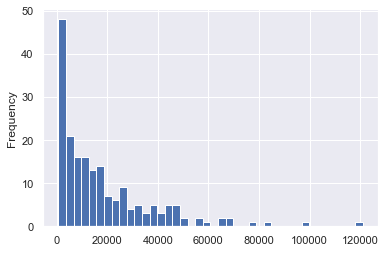

In [5]:
# Histogram of GDP per capita in 2018
(gap2018
 .gdppc
 .plot(kind='hist', bins=40));

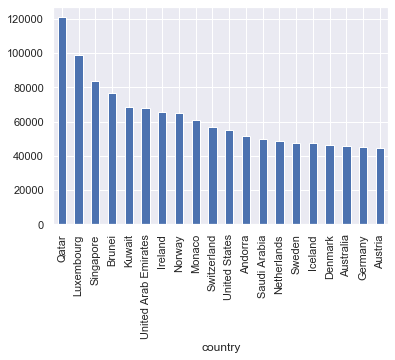

In [6]:
# GDP per capita of 20 ricest countries in 2018
(gap2018
 .gdppc
 .reset_index(level='year', drop=True)
 .nlargest(20)
 .plot(kind='bar')
);

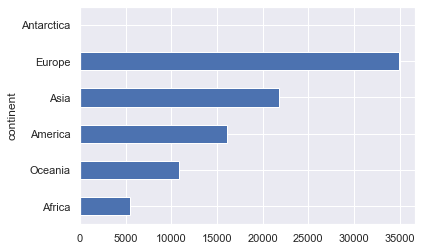

In [7]:
# Mean GDP per capita by continent in 2018
(gap2018
 .groupby('continent')
 .gdppc.mean()
 .sort_values()
 .plot(kind='barh')
);

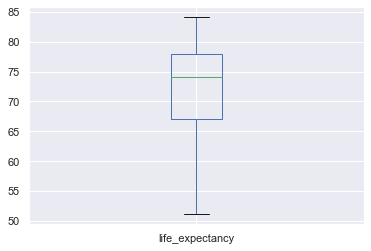

In [8]:
# Life expectancy in 2018
(gap2018
 .life_expectancy
 .plot(kind='box')
);

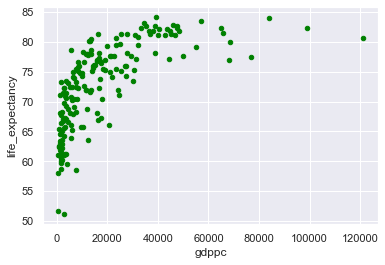

In [9]:
# Relationship between GDP per capita and life expectancy in 2018
(gap2018
.plot(kind='scatter',
     x='gdppc', 
     y='life_expectancy', 
     c='green')
);

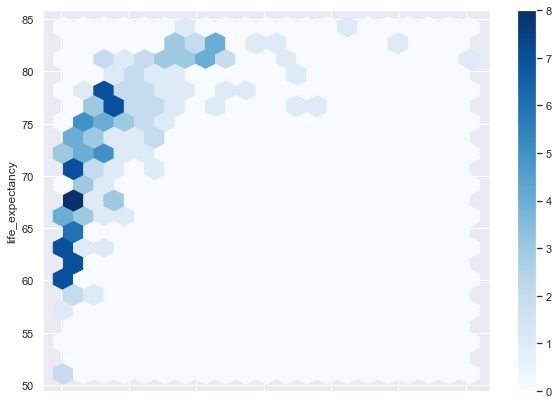

In [10]:
# Number of countries per (GDP per capita, life expectancy) combinarion in 2018
(gap2018
.plot(kind='hexbin',
      x='gdppc',
      y='life_expectancy',
      gridsize=20,
      cmap='Blues',
      figsize=(10,7)
     )
);

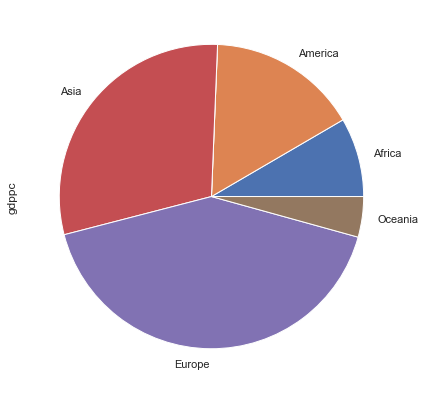

In [11]:
# Continent's share of total GDP per capita in 2018
(gap2018
 .groupby('continent')
 .gdppc
 .sum()
 .plot(kind='pie',
       figsize=(7,7)
      )
);

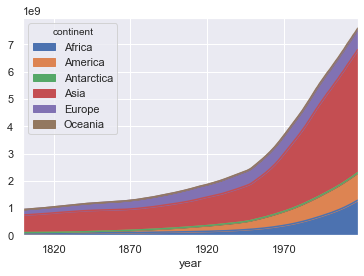

In [12]:
# Population growth since 1800
(gap
 .loc[idx[:, '1800':'2018'], :]
 .groupby(['year', 'continent'])
 .population.sum()
 .unstack()
 .plot(kind='area')
);

# Plotting using Seaborn 

In [13]:
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(7,5)}, 
    style="white" # nicer layout
)

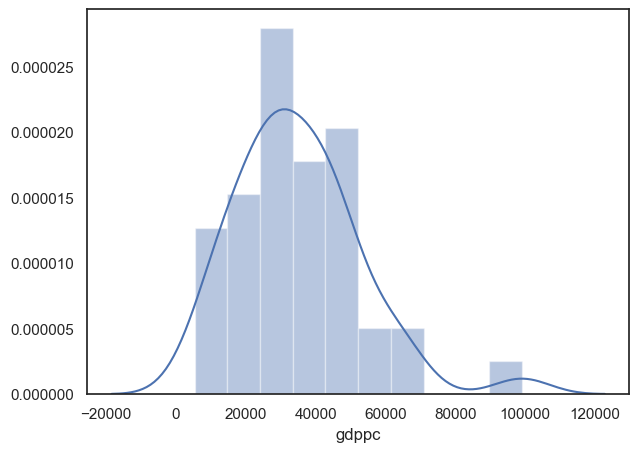

In [20]:
# Distribution of GDP per capita of European countries in 2018
sns_data = gap2018[
    (gap2018.gdppc.notnull()) & 
    (gap2018.continent=='Europe')
]

sns.distplot(
    sns_data.gdppc,
    label='GDP per capita',
    bins=10
);

''

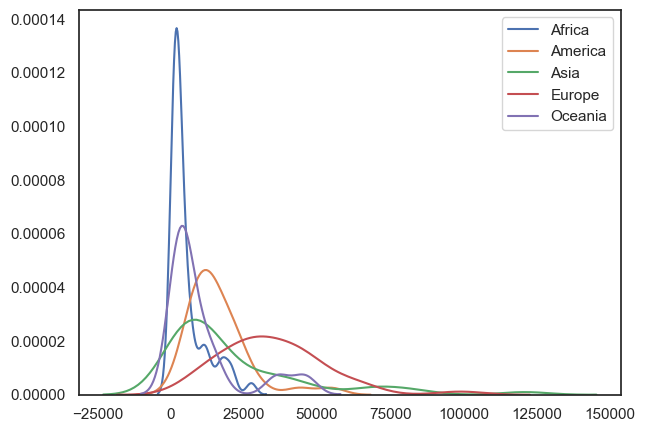

In [22]:
# Distribution of GDP per capita per continent
for c in gap2018.continent.cat.categories:
    _sns_data = gap2018[gap2018.continent == c]
    sns.kdeplot(
        _sns_data.gdppc,
        label=c
    )